In [62]:
import pandas as pd
from pandas import rolling_median
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


import helpers

# Manipulando Dados

O objetivo da atividade é exercitar a manipulação e preprocessamento de uma base de dados e utiliza-la num algoritmo de aprendizagem de máquina, como exemplo é utilizada a base de dados de passageiros do Titanic.


## Leitura dos dados

In [2]:
df = pd.read_csv('dataset/train.csv')

print(len(df))

df[:10]

891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## 1 - Pré-processamento dos dados

Foram aplicados alguns passo de pré-processamento dos dados que são descutidos a seguir

## 1.5 - Identificação e remoção de valores discrepantes

Nesse passo são verificados os dados da coluna 'Fare' a fim de identificar dados com valores discrepantes em relação aos demais. São utilizadas a média e o desvio padrão dos dados para a indeficação dos valores discrepantes 

### Distribuição dos dados antes da remoção dos valores discrepantes 

891

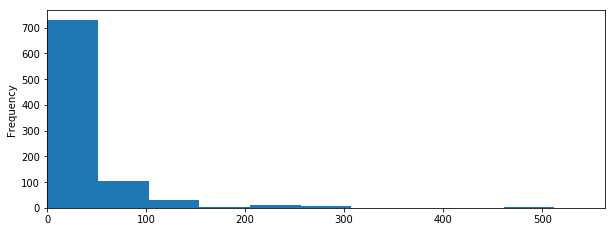

In [3]:
df = helpers.drop_nan_row(df, 'Fare')
helpers.plot_dist(df, 'Fare', 'hist')

len(df)

### Distribuição dos dados após a remoção dos valores discrepantes

853

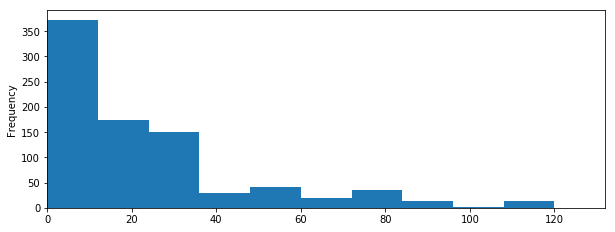

In [4]:
df = helpers.remove_outliers(df, "Fare", 2)

helpers.plot_dist(df, 'Fare', 'hist')

len(df)

## 1.2 Remoção de atributos

Alguns atributos dos dados foram desconsiderados, como: 'Name', 'Ticket', 'Cabin', entre outros, por conterem informações que consideramos desnecessárias ou por muitas informações inexistentes. 

## 1.3 Substituição de dados faltantes

Alguns dados possuem apenas alguns atributos com valor inexistente, por exemplo, apenas algumas linha não possuem o atributo 'Age', nesses casos foram atribuídos a média dos valores de todo o conjunto de dadosções

## 1.4 Conversão de dados

Algumas informações não estão em valor numérico, como 'Name' e 'Embarked', nesses casos, a strings foram consideradas como classes e essas classes foram utilizadas no lugar do valor original, por exemplo, os valore 'male' e 'female' são subistituídas pelos valores 0 e 1, respectivamente, que representam as 'classes' dos valores.

## 1.5 Normalização de dados

Atributos como 'Age' e 'Fate' possuem uma grande variação de valores, o que pode dificultar que o algoritmo de apredizagem aprenda os dados. Para sanar isso, os valores desses atributos foram normalizados para que apenas variem entre 0 e 1.

In [5]:
df = helpers.titanic_preprocessing_pipeline(df)

print(len(df))

df[:10]

851


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,0.271174,1,0,0.060417,2
1,1,1,0,0.472229,1,0,0.594027,0
2,1,3,0,0.321438,0,0,0.066042,2
3,1,1,0,0.434531,1,0,0.442500,2
4,0,3,1,0.434531,0,0,0.067083,2
5,0,3,1,0.359135,0,0,0.070486,1
6,0,1,1,0.673285,0,0,0.432187,2
7,0,3,1,0.019854,3,1,0.175625,2
8,1,3,0,0.334004,0,2,0.092777,2
9,1,2,0,0.170646,1,0,0.250590,0


## 2 - Correlação dos dados

Abaixo é apresentada a matriz de correlação dos atributos, isso é feito para se buscar por atributos com correlações fortes afim de eliminar um deles.

Na matriz de correlações dos dados trabalhados, a maior correção, em módulo, é entre 'Pclass' e 'Fate', com um correlação de aproximadamente '-0.65', o que não consideramos uma correlação suficientemente forte para eliminar um dos atributos.

In [6]:
df.corr(method='pearson', min_periods=1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.310760,-0.527310,-0.091792,-0.039654,0.084626,0.283083,-0.156813
Pclass,-0.310760,1.000000,0.086190,-0.345187,0.095298,0.065336,-0.653829,0.135044
Sex,-0.527310,0.086190,1.000000,0.102387,-0.117564,-0.254241,-0.188308,0.100581
Age,-0.091792,-0.345187,0.102387,1.000000,-0.231208,-0.184950,0.125261,-0.016744
SibSp,-0.039654,0.095298,-0.117564,-0.231208,1.000000,0.413043,0.314231,0.064016
Parch,0.084626,0.065336,-0.254241,-0.184950,0.413043,1.000000,0.247748,0.040314
Fare,0.283083,-0.653829,-0.188308,0.125261,0.314231,0.247748,1.000000,-0.201374
Embarked,-0.156813,0.135044,0.100581,-0.016744,0.064016,0.040314,-0.201374,1.000000


## 3 Utilizando os dados no treinamento

In [7]:
data_train = df.copy(deep=True)

data_test = pd.read_excel('dataset/titanic3.xls', sheet_name="titanic3")
data_test.columns = [x.lower() for x in data_test.columns]
data_test = helpers.titanic_preprocessing_pipeline(data_test)

In [8]:
y_train = data_train['Survived'].values
data_train = data_train.drop(['Survived'], axis=1)
x_train = data_train.values

y_test = data_test['survived'].values
data_test = data_test.drop(['survived'], axis=1)
x_test = data_test.values

In [19]:
y_train.shape

(851,)

## 3.1 Validação Cruzada

acc: 83.33%
acc: 83.33%
acc: 88.89%
acc: 83.33%
acc: 94.44%
acc: 83.33%
acc: 83.33%
acc: 72.22%
acc: 77.78%
acc: 83.33%
acc: 83.33%
acc: 77.78%
acc: 76.47%
acc: 94.12%
acc: 88.24%
acc: 82.35%
acc: 82.35%
acc: 76.47%
acc: 76.47%
acc: 88.24%
acc: 76.47%
acc: 82.35%
acc: 88.24%
acc: 82.35%
acc: 70.59%
acc: 88.24%
acc: 82.35%
acc: 88.24%
acc: 52.94%
acc: 64.71%
acc: 94.12%
acc: 82.35%
acc: 76.47%
acc: 82.35%
acc: 82.35%
acc: 70.59%
acc: 70.59%
acc: 76.47%
acc: 70.59%
acc: 68.75%
acc: 75.00%
acc: 81.25%
acc: 87.50%
acc: 81.25%
acc: 75.00%
acc: 93.75%
acc: 75.00%
acc: 68.75%
acc: 68.75%
acc: 81.25%


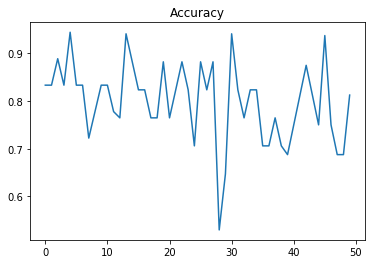

In [56]:
seed = 7
numpy.random.seed(seed)

kfold = StratifiedKFold(n_splits=50, shuffle=True, random_state=seed)

model = Sequential()
model.add(Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

acc_track = []

for train, test in kfold.split(x_train, y_train):
    model.fit(x_train[train], y_train[train], epochs=10, batch_size=10, verbose=0, shuffle=True)
    scores = model.evaluate(x_train[test], y_train[test], verbose=0)
    acc_track.append(scores[1])
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

plt.plot(acc_track)
plt.title('Accuracy')
plt.show()

In [60]:
y_pred = np.trunc(model.predict(x_test)).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print('Accuracy: {0:.3f}%'.format(acc*100))
print('Confusion Matrix: \n', matrix)

Accuracy: 70.291%
Confusion Matrix: 
 [[804   4]
 [384 114]]


## 3.2 Validação Cruzada + Dropout

acc: 94.44%
acc: 83.33%
acc: 94.44%
acc: 83.33%
acc: 33.33%
acc: 77.78%
acc: 83.33%
acc: 77.78%
acc: 77.78%
acc: 83.33%
acc: 83.33%
acc: 72.22%
acc: 76.47%
acc: 94.12%
acc: 82.35%
acc: 82.35%
acc: 70.59%
acc: 76.47%
acc: 88.24%
acc: 94.12%
acc: 76.47%
acc: 82.35%
acc: 88.24%
acc: 70.59%
acc: 70.59%
acc: 94.12%
acc: 94.12%
acc: 82.35%
acc: 76.47%
acc: 58.82%
acc: 88.24%
acc: 94.12%
acc: 70.59%
acc: 76.47%
acc: 82.35%
acc: 70.59%
acc: 82.35%
acc: 64.71%
acc: 94.12%
acc: 68.75%
acc: 81.25%
acc: 87.50%
acc: 93.75%
acc: 81.25%
acc: 75.00%
acc: 100.00%
acc: 93.75%
acc: 81.25%
acc: 68.75%
acc: 81.25%


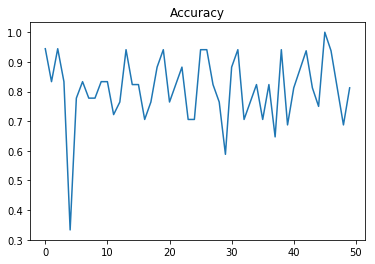

In [64]:
seed = 7
numpy.random.seed(seed)

kfold = StratifiedKFold(n_splits=50, shuffle=True, random_state=seed)

model = Sequential()
model.add(Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

acc_track = []

for train, test in kfold.split(x_train, y_train):
    model.fit(x_train[train], y_train[train], epochs=10, batch_size=10, verbose=0, shuffle=True)
    scores = model.evaluate(x_train[test], y_train[test], verbose=0)
    acc_track.append(scores[1])
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

plt.plot(acc_track)
plt.title('Accuracy')
plt.show()

In [66]:
y_pred = np.trunc(model.predict(x_test)).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print('Accuracy: {0:.3f}%'.format(acc*100))
print('Confusion Matrix: \n', matrix)

Accuracy: 66.386%
Confusion Matrix: 
 [[806   2]
 [437  61]]
